# Demonstration of baseflow separation using the Institute of Hydrology/BFI methods

original documentation:
Institute of Hydrology, 1980, Low flow studies report no. 3--Research report: 
Wallingford, Oxon, United Kingdom, Institute of Hydrology Report no. 3, p. 12-19, available at: http://nora.nerc.ac.uk/9098/1/Low_Flow_03.pdf  
[MS word version](http://www.clemson.edu/ces/hydro/murdoch/Courses/Aquifer%20Systems/Modeling/modeling%20exercises.htm) prepared by Larry Murdoch of Clemson University

Wahl, K.L and Wahl, T.L., 1988. Effects of regional ground-water level declines
on streamflow in the Oklahoma Panhandle. In Proceedings of the Symposium on 
Water-Use Data for Water Resources Management, American Water Resources Association.

In [1]:
import sys
sys.path.append('/Users/aleaf/Documents/GitHub/NWIS')
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from nwis.baseflow import IHmethod

% matplotlib inline

mpl.rcParams['figure.figsize'] = (11, 8.5)

### input files

In [2]:
pangdata = 'pang.csv' # hydrograph for the Pang River IH (1980) example
pangresultsfile = 'pangbf.csv' # results from table 3.2a of IH (1980)

#### read input files into pandas dataframes

In [3]:
# benchmark IHmethod on Pang example (from original documentation)
df = pd.read_csv(pangdata, index_col='date', parse_dates=True)
pangresults = pd.read_csv(pangresultsfile)
df.head()

,Q
date,
1970-01-01,0.422
1970-01-02,0.426
1970-01-03,0.421
1970-01-04,0.398
1970-01-05,0.389


In [4]:
pangresults.head()

,Date of turning point,Discharge (cumecs),Time span between turning points (days),Average discharge (cumecs),Increment of Baseflow (cumec-days)
0,7/1,0.364,10.0,0.496,4.96
1,17/1,0.628,4.0,0.637,2.55
2,21/1,0.645,16.0,0.701,11.21
3,6/2,0.756,5.0,0.731,3.66
4,11/2,0.706,4.0,0.687,2.75


### BFI parameters

In [5]:
block_length = 5 # days
turning_point = 0.9 # fraction of adjacent flows
interp_semilog = True # semilog or linear interpolation between turning points

### IH/BFI proceedure

#### 1) Divide the mean daily flow data into non-overlapping blocks of `block_length` days
calculate the minima for each of these blocks, and let them be called $Q1, Q2, Q3...Qn.$

In [6]:
# compute block numbers for grouping values on blocks
nblocks = int(np.floor(len(df) / float(block_length)))

# make list of ints, one per measurement, denoting the block
# eg [1,1,1,1,1,2,2,2,2,2...] for block_length = 5
n = []
for i in range(nblocks):
    n += [i + 1] * block_length
n += [np.nan] * (len(df) - len(n))  # pad any leftover values with nans
df['n'] = n
df.head()

,Q,n
date,,
1970-01-01,0.422,1.0
1970-01-02,0.426,1.0
1970-01-03,0.421,1.0
1970-01-04,0.398,1.0
1970-01-05,0.389,1.0


In [7]:
# create dataframe Q, which only has minimums for each block
Q = df.groupby('n').min()
Q = Q.rename(columns={'Q': 'block_Qmin'})
Q['n'] = Q.index
Q['datetime'] = df[['Q', 'n']].groupby('n').idxmin()  # include dates of minimum values
Q.head()

,block_Qmin,n,datetime
n,,,
1.0,0.389,1.0,1970-01-05
2.0,0.364,2.0,1970-01-07
3.0,0.630,3.0,1970-01-13
4.0,0.628,4.0,1970-01-17
5.0,0.645,5.0,1970-01-21


#### 2) Compute ordinates (turning points)
* Consider in turn $(Q1, Q2, Q3,), (Q2, Q3, Q4),...(Qi-1, Qi, Qi+1)$ etc.
* In each case, if 0.9  x  central value < outer values, then the central value is an ordinate for the base flow line.  
* Continue this procedure until all the data have been analysed to provide a derived set of base flow ordinates $QB1, QB2, QB3,...QBn$ which will have different time periods between them.

In [8]:
# compute baseflow ordinates
Q['ordinate'] = [np.nan] * len(Q)
Qlist = Q.block_Qmin.tolist()
Q['Qi-1'] = [np.nan] + Qlist[:-2] + [np.nan]
Q['Qi'] = [np.nan] + Qlist[1:-1] + [np.nan]
Q['Qi+1'] = [np.nan] + Qlist[2:] + [np.nan]
isordinate = turning_point * Q.Qi < Q[['Qi-1', 'Qi+1']].min(axis=1)
Q.loc[isordinate, 'ordinate'] = Q.loc[isordinate, 'block_Qmin']

# reset the index of Q to datetime
Q.index = Q.datetime
Q.head()

,block_Qmin,n,datetime,ordinate,Qi-1,Qi,Qi+1
datetime,,,,,,,
1970-01-05,0.389,1.0,1970-01-05,NaN,NaN,NaN,NaN
1970-01-07,0.364,2.0,1970-01-07,0.364,0.389,0.364,0.630
1970-01-13,0.630,3.0,1970-01-13,NaN,0.364,0.630,0.628
1970-01-17,0.628,4.0,1970-01-17,0.628,0.630,0.628,0.645
1970-01-21,0.645,5.0,1970-01-21,0.645,0.628,0.645,0.786


#### 3) By linear interpolation between each QBi value, estimate each daily value of $QB1...QBn$
in the BFI program, semi-logarithmic interpolation is used

In [9]:
# expand Q dataframe back out to include row for each day
Q = Q.dropna(subset=['datetime'], axis=0).resample('D').mean()

# interpolate between baseflow ordinates
if interp_semilog:
    iszero = Q.ordinate.values == 0
    logQ = np.log10(Q.ordinate)
    logQ[iszero] = -2
    QB = np.power(10.0, logQ.interpolate(limit=100).values)
else:
    QB = Q.ordinate.interpolate(limit=100).values
Q['QB'] = QB

# reassign the original flow values back to Q
Q['Q'] = df.Q.loc[Q.index]
Q.head()

,block_Qmin,n,ordinate,Qi-1,Qi,Qi+1,QB,Q
datetime,,,,,,,,
1970-01-05,0.389,1.0,NaN,NaN,NaN,NaN,NaN,0.389
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395
1970-01-07,0.364,2.0,0.364,0.389,0.364,0.63,0.364000,0.364
1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,0.384403,0.379
1970-01-09,NaN,NaN,NaN,NaN,NaN,NaN,0.405950,0.593


#### 4) If QBi > Qi then set QBi = Qi

In [10]:
# ensure that no baseflow values are > Q measured
QBgreaterthanQ = Q.QB.values > Q.Q.values
Q.loc[QBgreaterthanQ, 'QB'] = Q.loc[QBgreaterthanQ, 'Q']

/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


### Compare with results from original report
<img src="pangresults.png" alt="Drawing" align='left' style="width: 700px;"/>


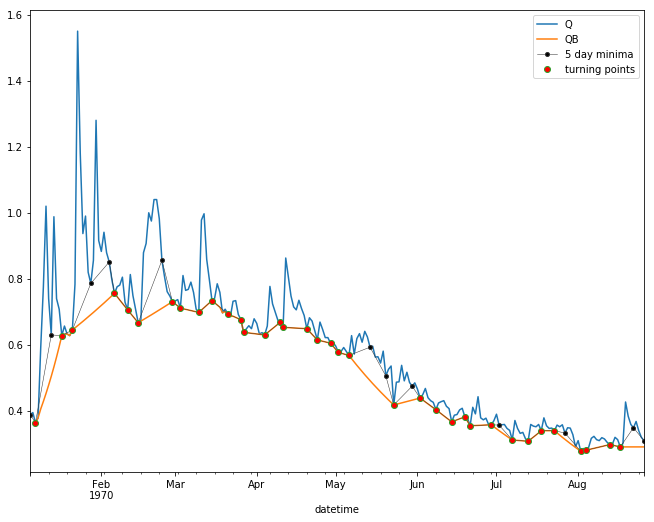

In [11]:
ax = Q[['Q', 'QB']].plot()
minima = Q.block_Qmin.dropna().plot(ax=ax, lw=0.5, c='0.2', mfc='k',
                                    marker='o', markersize=4,
                                    label='{} day minima'.format(block_length))
ords = Q.ordinate.dropna().plot(ax=ax, marker='o', mfc='r', lw=0, markersize=6,
                                label='turning points')
plt.legend()

In [12]:
pangresults.head()

,Date of turning point,Discharge (cumecs),Time span between turning points (days),Average discharge (cumecs),Increment of Baseflow (cumec-days)
0,7/1,0.364,10.0,0.496,4.96
1,17/1,0.628,4.0,0.637,2.55
2,21/1,0.645,16.0,0.701,11.21
3,6/2,0.756,5.0,0.731,3.66
4,11/2,0.706,4.0,0.687,2.75


In [13]:
Q.dropna(subset=['ordinate']).Q.values - pangresults['Discharge (cumecs)'].values

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.0003,  0.0003,  0.0003,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ])

In [14]:
# Total volume beneath baseflow and recorded hydrographs
VB = Q.ix['1-7-1970':'8-17-1970', 'QB'].round(3).sum()
VA = Q.ix['1-7-1970':'8-17-1970', 'Q'].round(3).sum() # matches example data but not reported sum
BFI = VB/VA
VB, VA, BFI

(116.68800000000014, 132.17399999999998, 0.8828362612919346)

### `nwis.baseflow.IHmethod()`

In [15]:
Q2 = IHmethod(df.Q)

/Users/aleaf/Documents/GitHub/NWIS/nwis/baseflow.py:194: RuntimeWarning: invalid value encountered in greater
  QBgreaterthanQ = Q.QB.values > Q.Q.values


In [17]:
Q2.head()

,block_Qmin,n,ordinate,Qi-1,Qi,Qi+1,QB,Q
datetime,,,,,,,,
1970-01-05,0.389,1.0,NaN,NaN,NaN,NaN,NaN,0.389
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395
1970-01-07,0.364,2.0,0.364,0.389,0.364,0.63,0.36400,0.364
1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,0.37900,0.379
1970-01-09,NaN,NaN,NaN,NaN,NaN,NaN,0.40595,0.593


In [16]:
Q2.dropna(subset=['ordinate']).Q.values - pangresults['Discharge (cumecs)'].values

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.0003,  0.0003,  0.0003,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ])